In [1]:
import geopandas as pd
import contextily as ctx # Used for contextual basemaps
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube # Used for rasterizing
import os
import shapely
import imageio # Used for making animated GIFs
import numpy as np
from IPython.display import Image
from osgeo import gdal # Raster operations
import zipfile
import rasterio
import rasterio.merge
import rasterio.plot
import rasterio.warp
plt.rcParams['figure.figsize'] = (20, 20)
os.listdir("input")

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


['lds-nz-road-centrelines-topo-150k-FGDB.zip',
 'lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip',
 'statsnzpopulation-by-meshblock-2013-census-FGDB.zip',
 'statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip',
 'statsnzregional-council-2021-clipped-generalised-FGDB.zip',
 'lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip']

First, read regional council bounds. This geometry will be used to clip NZ-wide datasets to just the region of interest, Auckland

epsg:2193
CPU times: user 1.7 s, sys: 67.9 ms, total: 1.77 s
Wall time: 15.4 s


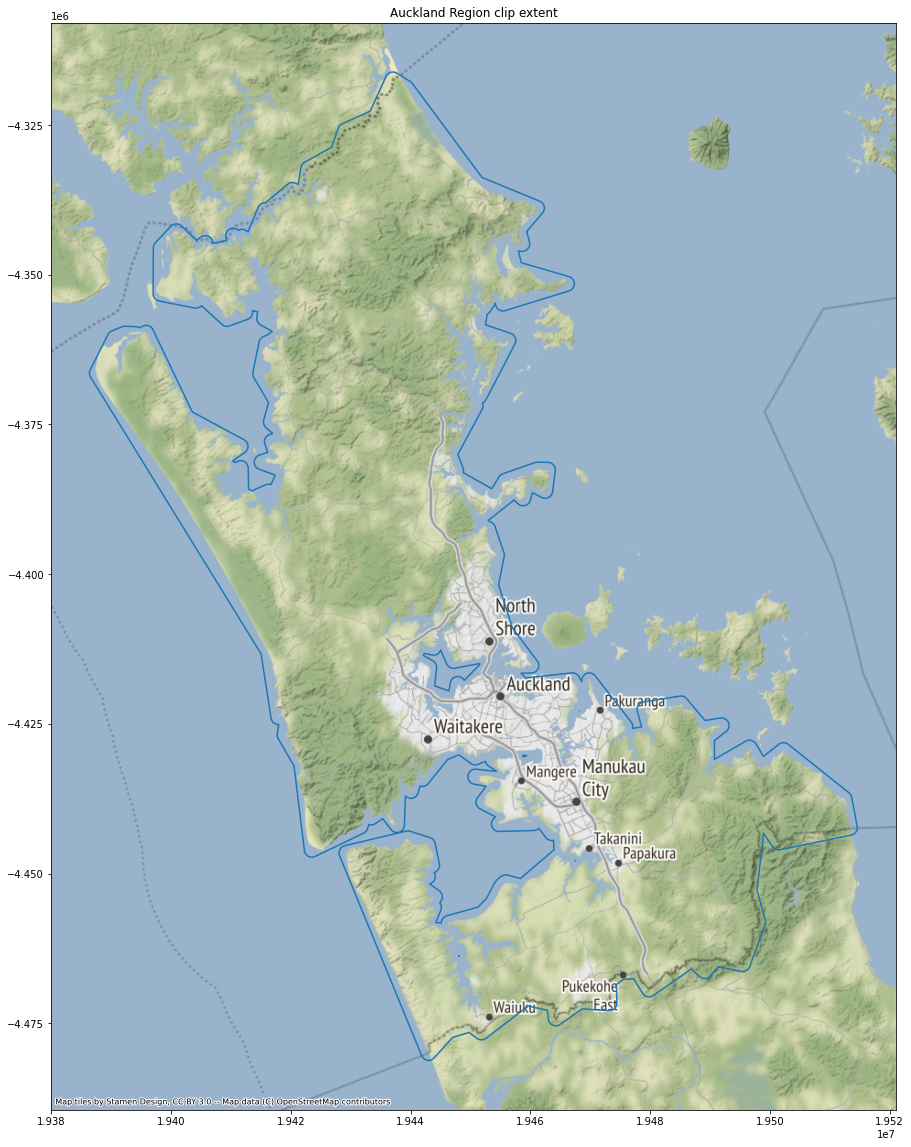

In [2]:
%%time
REGC = pd.read_file("input/statsnzregional-council-2021-clipped-generalised-FGDB.zip!regional-council-2021-clipped-generalised.gdb")
AKL = REGC[REGC.REGC2021_V1_00_NAME == "Auckland Region"].copy()
# Filter out islands
AKL["geometry"] = max(AKL.geometry.explode(), key=lambda a: a.area)
# Coordinate reference system (projection)
print(AKL.crs)
# Simplify geometry to speed up clip operations
AKL = AKL.simplify(1000).buffer(1000)
ax = AKL.to_crs(epsg=3857).boundary.plot()
ax.set_title("Auckland Region clip extent")
ctx.add_basemap(ax)

## Land use
Load the LRIS Land Cover Database (downloaded in GDB format from https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/)

In [3]:
%%time
df = pd.read_file("zip://input/lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip!lcdb-v50-land-cover-database-version-50-mainland-new-zealand.gdb")

CPU times: user 1min 31s, sys: 1.74 s, total: 1min 32s
Wall time: 1min 32s


In [4]:
print(df.columns)
print(df.crs)
display(df.sample(5))

Index(['Name_2018', 'Name_2012', 'Name_2008', 'Name_2001', 'Name_1996',
       'Class_2018', 'Class_2012', 'Class_2008', 'Class_2001', 'Class_1996',
       'Wetland_18', 'Wetland_12', 'Wetland_08', 'Wetland_01', 'Wetland_96',
       'Onshore_18', 'Onshore_12', 'Onshore_08', 'Onshore_01', 'Onshore_96',
       'EditAuthor', 'EditDate', 'LCDB_UID', 'geometry'],
      dtype='object')
epsg:2193


Name_2018                         Name_2012  \
502146           Low Producing Grassland           Low Producing Grassland   
71545               Sub Alpine Shrubland              Sub Alpine Shrubland   
308506                     Exotic Forest                     Exotic Forest   
141898  Broadleaved Indigenous Hardwoods  Broadleaved Indigenous Hardwoods   
450335  Broadleaved Indigenous Hardwoods  Broadleaved Indigenous Hardwoods   

                               Name_2008                         Name_2001  \
502146           Low Producing Grassland           Low Producing Grassland   
71545               Sub Alpine Shrubland              Sub Alpine Shrubland   
308506                     Exotic Forest                     Exotic Forest   
141898  Broadleaved Indigenous Hardwoods  Broadleaved Indigenous Hardwoods   
450335  Broadleaved Indigenous Hardwoods  Broadleaved Indigenous Hardwoods   

                               Name_1996  Class_2018  Class_2012  Class_2008  \
502146           Low Producing Grassland          41          41          41   
71545               Sub Alpine Shrubland          55          55          55   
308506                     Exotic Forest          71          71          71   
141898  Broadleaved Indigenous Hardwoods          54          54          54   
450335  Broadleaved Indigenous Hardwoods          54          54          54   

        Class_2001  Class_1996  ... Wetland_96 Onshore_18 Onshore_12  \
502146          41          41  ...         no        yes        yes   
71545           55          55  ...         no        yes        yes   
308506          71          71  ...         no        yes        yes   
141898          54          54  ...         no        yes        yes   
450335          54          54  ...         no        yes        yes   

       Onshore_08 Onshore_01 Onshore_96 EditAuthor             EditDate  \
502146        yes        yes        yes  Terralink  2004-06-30T00:00:00   
71545         yes        yes        yes  Terralink  2004-06-30T00:00:00   
308506        yes        yes        yes  Terralink  2004-06-30T00:00:00   
141898        yes        yes        yes  Terralink  2004-06-30T00:00:00   
450335        yes        yes        yes  Terralink  2004-06-30T00:00:00   

              LCDB_UID                                           geometry  
502146  lcdb2000074984  MULTIPOLYGON (((1571018.770 5440396.135, 15710...  
71545   lcdb2000156429  MULTIPOLYGON (((1554137.727 5333760.660, 15541...  
308506  lcdb1000219355  MULTIPOLYGON (((1746445.097 5941708.713, 17464...  
141898  lcdb1000123504  MULTIPOLYGON (((1726441.403 6058244.084, 17264...  
450335  lcdb1000121444  MULTIPOLYGON (((1744411.791 5922389.063, 17444...  

[5 rows x 24 columns]

In [5]:
%%time
df = pd.clip(df, AKL)

CPU times: user 51.4 s, sys: 10.2 ms, total: 51.4 s
Wall time: 51.4 s


In [6]:
df.sample(5)

Name_2018                        Name_2012  \
465028  High Producing Exotic Grassland  High Producing Exotic Grassland   
362917             Manuka and/or Kanuka             Manuka and/or Kanuka   
387580                Indigenous Forest                Indigenous Forest   
284920        Urban Parkland/Open Space        Urban Parkland/Open Space   
327262                    Exotic Forest                    Exotic Forest   

                              Name_2008                        Name_2001  \
465028  High Producing Exotic Grassland  High Producing Exotic Grassland   
362917             Manuka and/or Kanuka             Manuka and/or Kanuka   
387580                Indigenous Forest                Indigenous Forest   
284920        Urban Parkland/Open Space        Urban Parkland/Open Space   
327262                    Exotic Forest                    Exotic Forest   

                              Name_1996  Class_2018  Class_2012  Class_2008  \
465028  High Producing Exotic Grassland          40          40          40   
362917             Manuka and/or Kanuka          52          52          52   
387580                Indigenous Forest          69          69          69   
284920        Urban Parkland/Open Space           2           2           2   
327262  High Producing Exotic Grassland          71          71          71   

        Class_2001  Class_1996  ... Wetland_96 Onshore_18 Onshore_12  \
465028          40          40  ...         no        yes        yes   
362917          52          52  ...         no        yes        yes   
387580          69          69  ...         no        yes        yes   
284920           2           2  ...         no        yes        yes   
327262          71          40  ...         no        yes        yes   

       Onshore_08 Onshore_01 Onshore_96         EditAuthor  \
465028        yes        yes        yes          Terralink   
362917        yes        yes        yes  Landcare Research   
387580        yes        yes        yes          Terralink   
284920        yes        yes        yes          Terralink   
327262        yes        yes        yes  Landcare Research   

                   EditDate        LCDB_UID  \
465028  2004-06-30T00:00:00  lcdb1000038619   
362917  2019-12-01T00:00:00  lcdb1000094293   
387580  2004-06-30T00:00:00  lcdb1000166887   
284920  2004-06-30T00:00:00  lcdb1000005519   
327262  2014-06-30T00:00:00  lcdb1000411422   

                                                 geometry  
465028  POLYGON ((1738028.812 5952565.276, 1738046.749...  
362917  POLYGON ((1729731.592 5935855.464, 1729746.120...  
387580  POLYGON ((1738608.703 5966393.969, 1738564.711...  
284920  POLYGON ((1772944.068 5895849.135, 1772927.582...  
327262  POLYGON ((1746175.321 5938658.358, 1746180.264...  

[5 rows x 24 columns]

In [7]:
df.Name_2018.value_counts()

Exotic Forest                                3981
Indigenous Forest                            3673
Manuka and/or Kanuka                         2282
Broadleaved Indigenous Hardwoods             1788
Built-up Area (settlement)                   1350
High Producing Exotic Grassland              1326
Mangrove                                     1151
Urban Parkland/Open Space                    1099
Estuarine Open Water                          441
Orchard, Vineyard or Other Perennial Crop     436
Short-rotation Cropland                       362
Lake or Pond                                  326
Herbaceous Saline Vegetation                  303
Low Producing Grassland                       291
Gorse and/or Broom                            287
Forest - Harvested                            266
Sand or Gravel                                252
Deciduous Hardwoods                           201
Surface Mine or Dump                          132
Mixed Exotic Shrubland                        120


These classes are far too detailed - simplify to just Urban, Vegetation, Water, Other

In [8]:
def simplify_classes(code):
    if code in [1, 2, 5]:
        return 1, "Urban"
    elif code in [68,69,71]:
        return 2, "Vegetation"
    elif code in [0,20,21,22,45,46]:
        return 3, "Water"
    else:
        return 4, "Other"

summary = []
years = [1996, 2001, 2008, 2012, 2018]
for year in years:
    print(year)
    class_year = f"Class_{year}"
    df[class_year + "_simplified_code"] = df[class_year].apply(lambda c: simplify_classes(c)[0])
    df[class_year + "_simplified_name"] = df[class_year].apply(lambda c: simplify_classes(c)[1])
    summary.append(df[class_year + "_simplified_name"].value_counts())

1996
2001
2008
2012
2018


<AxesSubplot:>

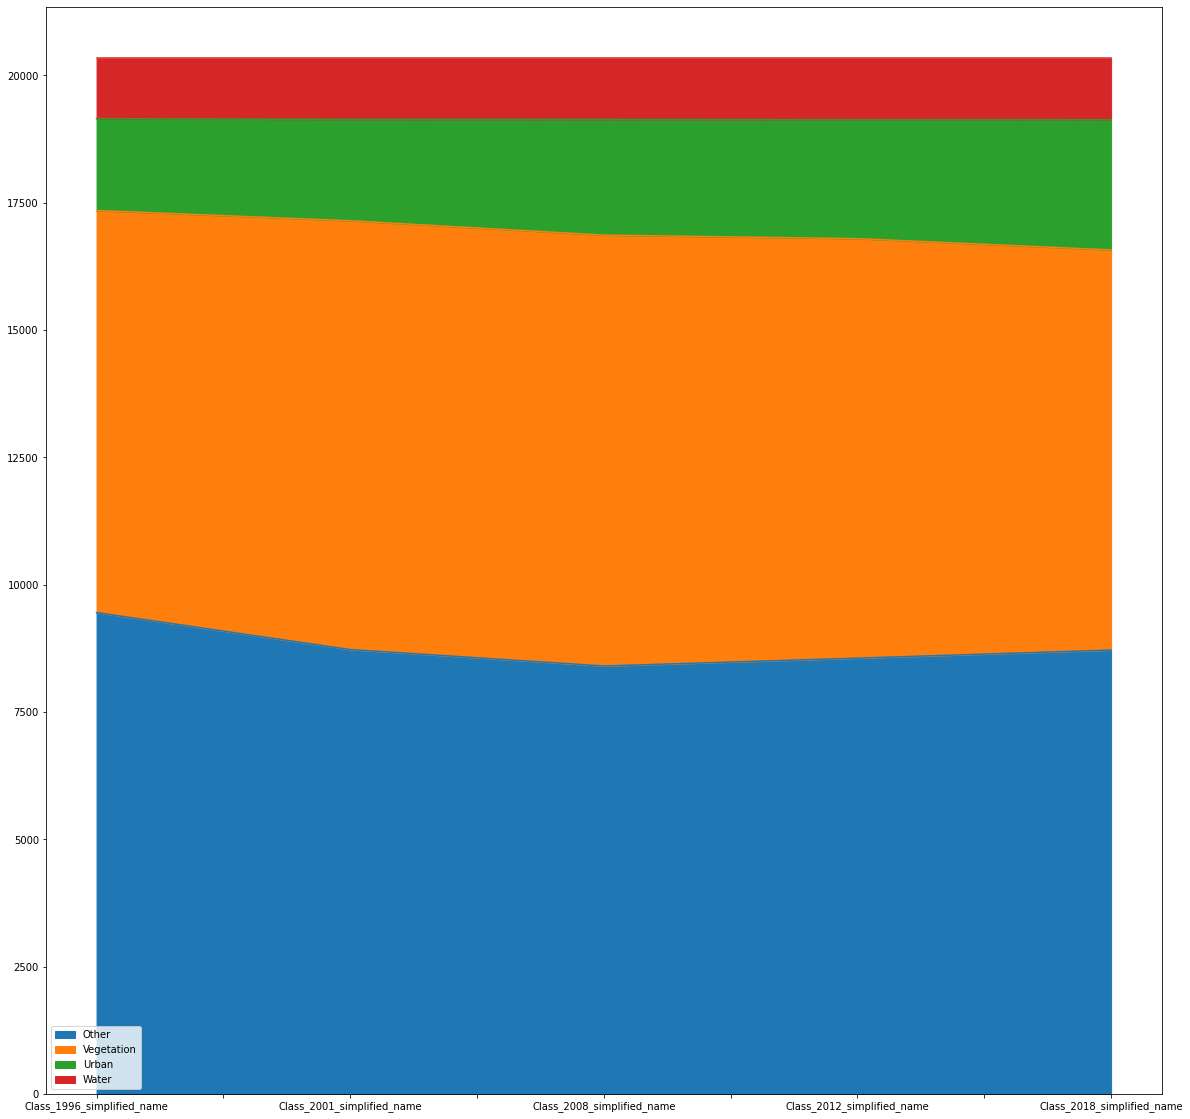

In [9]:
pd.GeoDataFrame(summary).plot.area()

In [10]:
%%capture
# %%capture suppresses output
if not os.path.isfile("land_use.gif"):
    ims = []
    years = [1996, 2001, 2008, 2012, 2018]
    for year in years:
        ax = df.plot(column=f'Class_{year}_simplified_name', legend=True)
        ax.set_title(year)
        ax.figure.tight_layout()
        canvas = ax.figure.canvas
        canvas.draw() # draw the canvas, cache the renderer
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(canvas.get_width_height()[::-1] + (3,))
        ims.append(image)
    imageio.mimsave("land_use.gif", ims, fps=1)

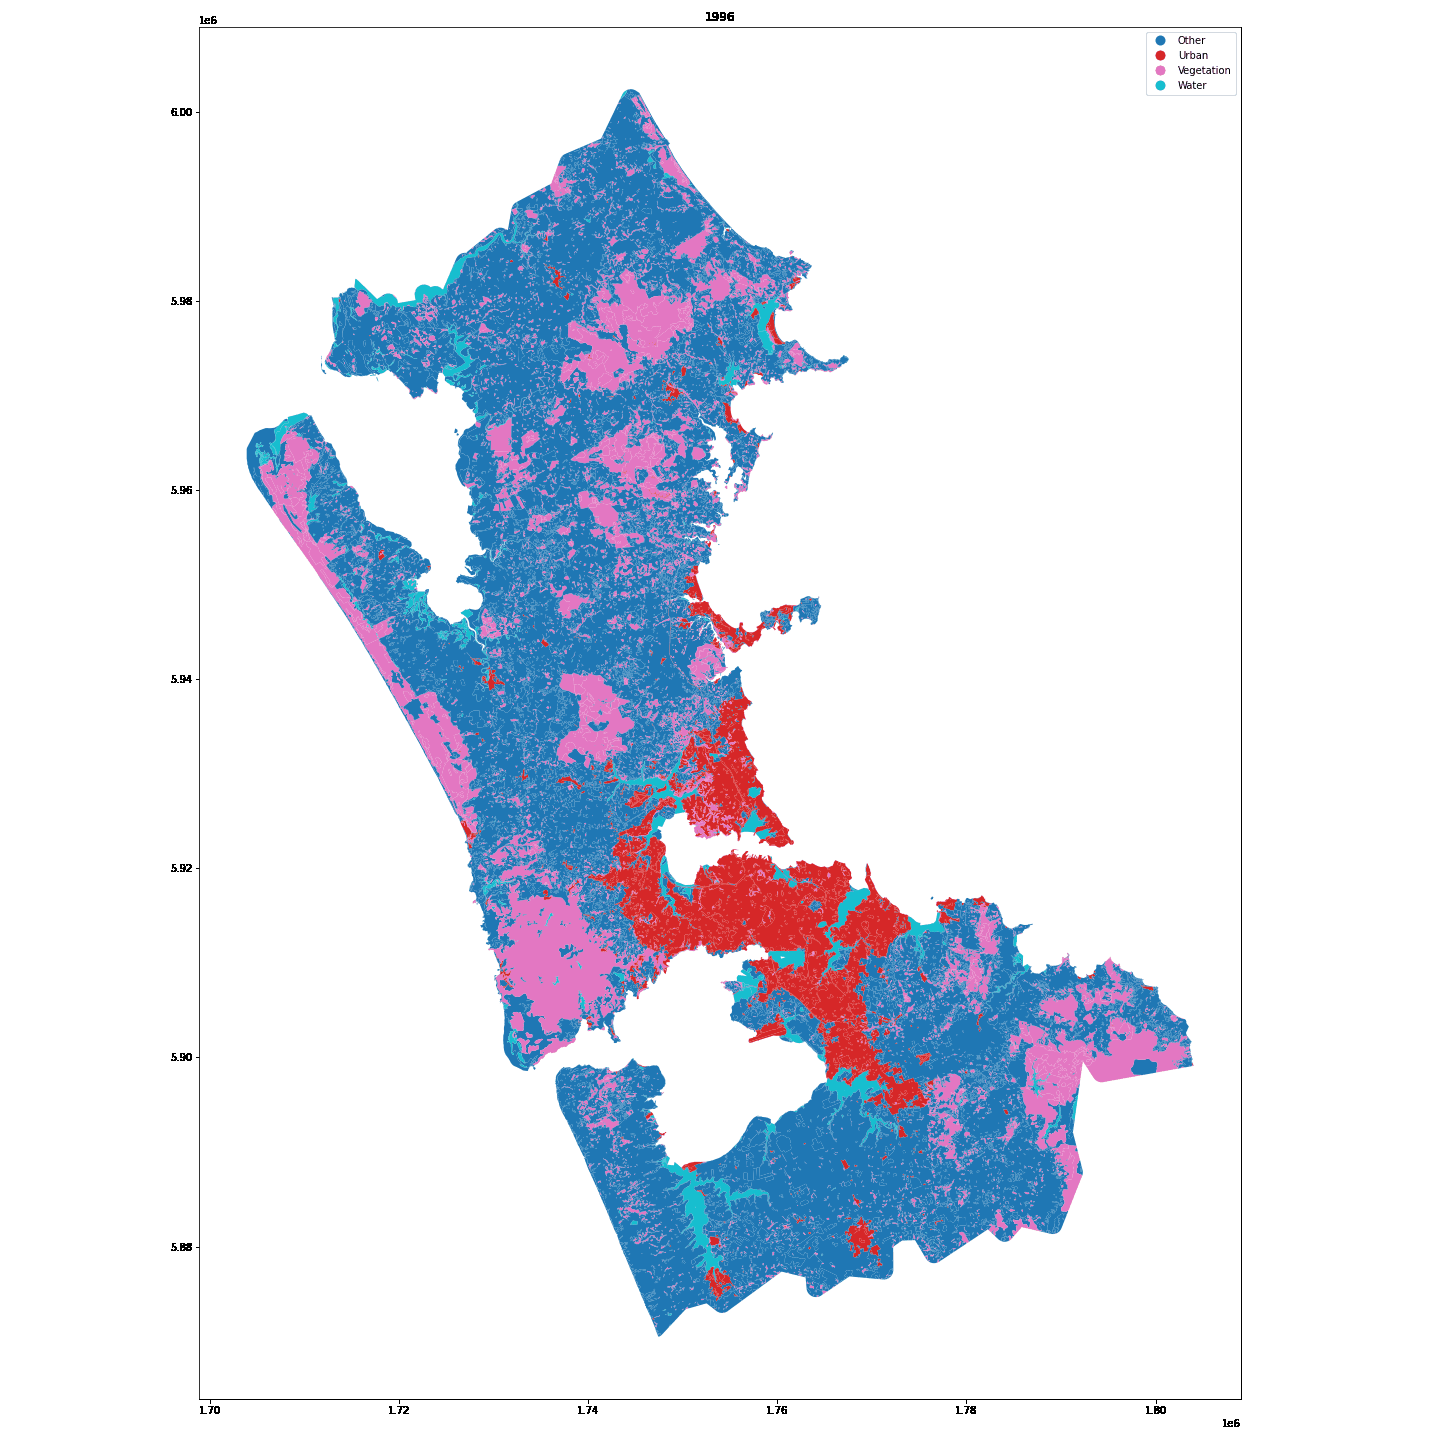

In [11]:
with open('land_use.gif','rb') as file:
    display(Image(file.read()))

In [12]:
cols = [f"Class_{year}_simplified_code" for year in years]
cols

['Class_1996_simplified_code',
 'Class_2001_simplified_code',
 'Class_2008_simplified_code',
 'Class_2012_simplified_code',
 'Class_2018_simplified_code']

In [13]:
%%time
geocube = make_geocube(
    vector_data=df,
    output_crs="epsg:2193",
    measurements=cols,
    resolution=(-100, 100),
    fill=0, # NaNs, like offshore areas, will be 0
)
geocube

CPU times: user 15.8 s, sys: 9.8 ms, total: 15.8 s
Wall time: 15.8 s


<xarray.Dataset>
Dimensions:                     (x: 1001, y: 1320)
Coordinates:
  * y                           (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                           (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                 int64 0
Data variables:
    Class_1996_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2001_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2008_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2012_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2018_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

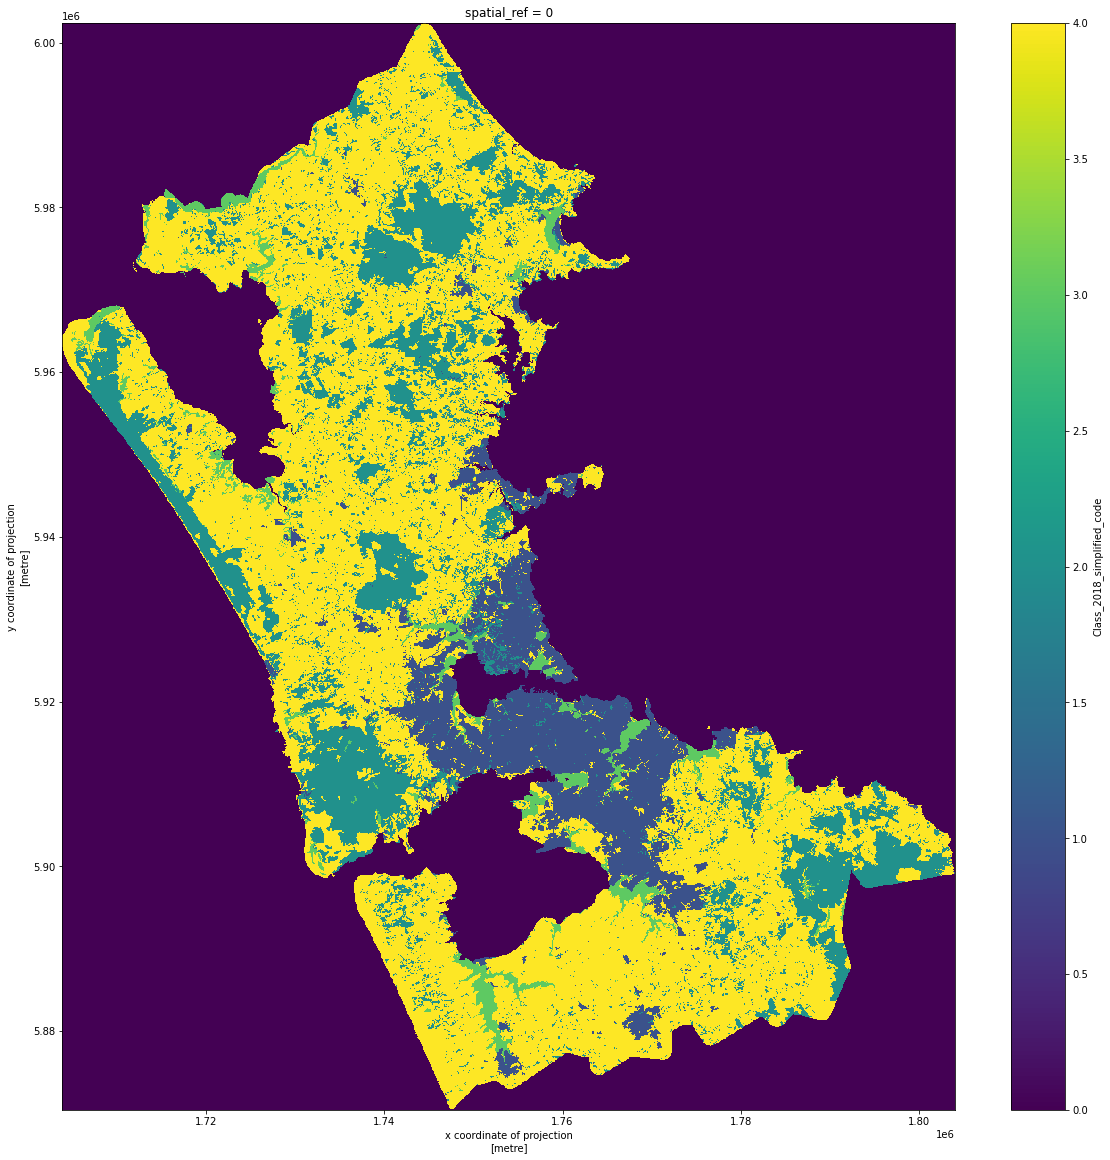

In [14]:
geocube.Class_2018_simplified_code.plot()

In [15]:
for year in years:
    print(year)
    outfile = f"output/land_use_{year}.tif"
    if not os.path.isfile(outfile):
        geocube[f"Class_{year}_simplified_code"].rio.to_raster(outfile, dtype=np.byte) # Use np.byte for smaller output filesize

1996
2001
2008
2012
2018


## Population density

In [16]:
%%time
pop2013 = pd.read_file("input/statsnzpopulation-by-meshblock-2013-census-FGDB.zip!population-by-meshblock-2013-census.gdb")

CPU times: user 8.51 s, sys: 156 µs, total: 8.51 s
Wall time: 8.5 s


In [17]:
%%time
pop2013 = pd.clip(pop2013, AKL)

CPU times: user 20.6 s, sys: 0 ns, total: 20.6 s
Wall time: 20.6 s


In [18]:
display(pop2013.sample(5))

Meshblock MeshblockNumber  Population_Count_Usual_Resident_2013  \
17488  MB 0646600         0646600                                   138   
11200  MB 0175133         0175133                                    63   
11195  MB 0175123         0175123                                    54   
20017  MB 0791300         0791300                                   165   
16170  MB 0537900         0537900                                   102   

       Population_Count_Census_Night_2013  \
17488                                 135   
11200                                  63   
11195                                  54   
20017                                 168   
16170                                 105   

                                                geometry  
17488  POLYGON ((1771691.033 5915038.381, 1771686.313...  
11200  POLYGON ((1760443.546 5946072.779, 1760442.977...  
11195  POLYGON ((1760143.382 5946335.535, 1760111.742...  
20017  POLYGON ((1772496.814 5896867.747, 1772505.285...  
16170  POLYGON ((1755058.091 5915933.915, 1754793.205...

In [19]:
#pop2013.Population_Count_Usual_Resident_2013.replace(0, np.nan, inplace=True)

<AxesSubplot:ylabel='Frequency'>

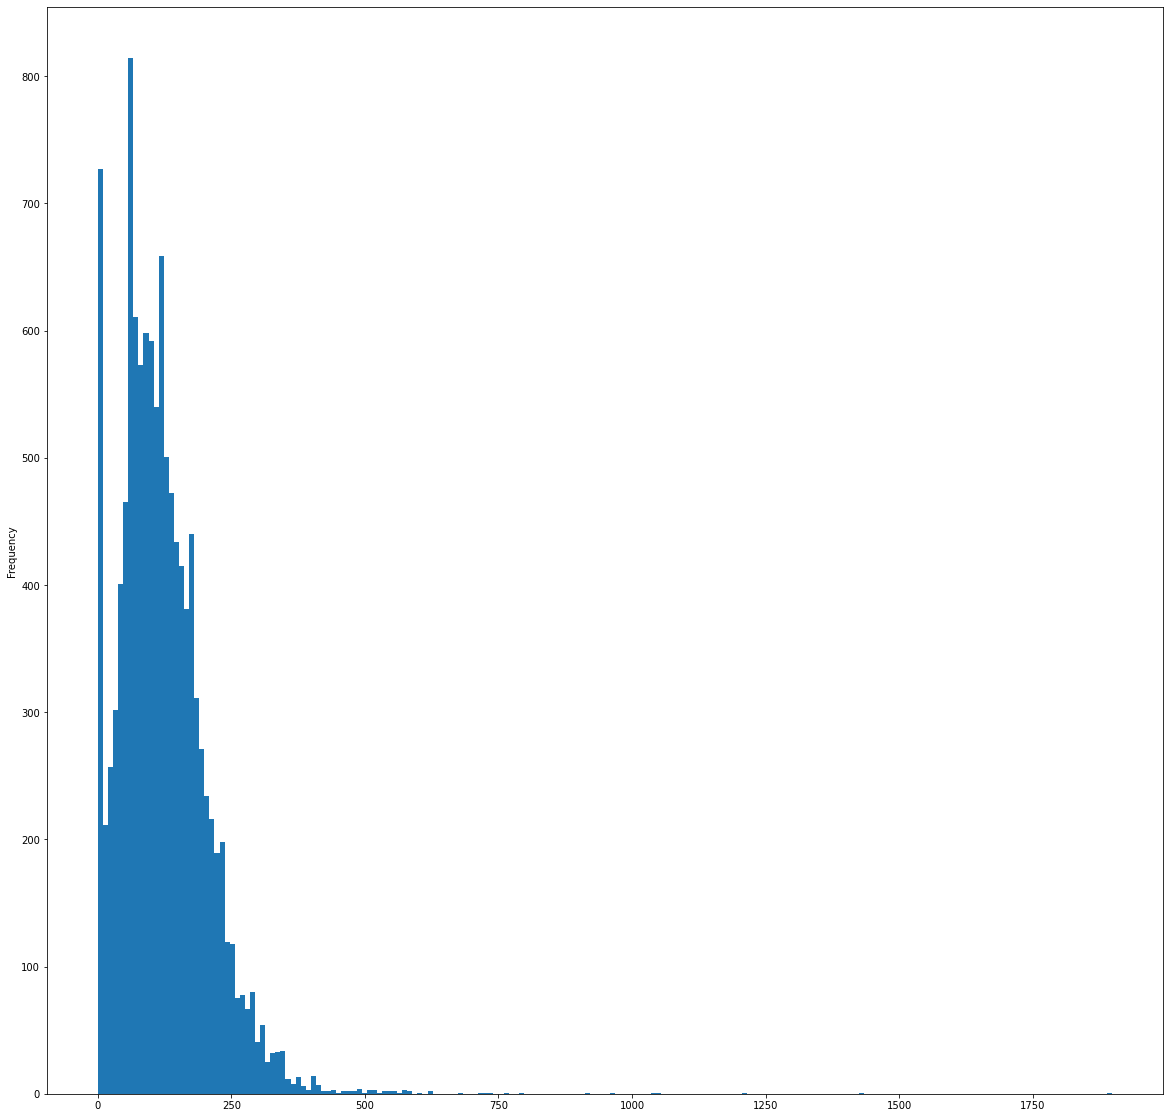

In [20]:
pop2013.Population_Count_Usual_Resident_2013.plot(kind="hist", bins=200)

In [21]:
%%time
pop2013_cube = make_geocube(
    vector_data=pop2013,
    measurements=["Population_Count_Usual_Resident_2013"],
    like=geocube, # Ensures dimensions match
    fill=0 # NaNs, like offshore areas, will be 0
)
pop2013_cube

CPU times: user 2.15 s, sys: 10.1 ms, total: 2.16 s
Wall time: 2.16 s


<xarray.Dataset>
Dimensions:                               (x: 1001, y: 1320)
Coordinates:
  * y                                     (y) float64 6.002e+06 ... 5.87e+06
  * x                                     (x) float64 1.704e+06 ... 1.804e+06
    spatial_ref                           int64 0
Data variables:
    Population_Count_Usual_Resident_2013  (y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

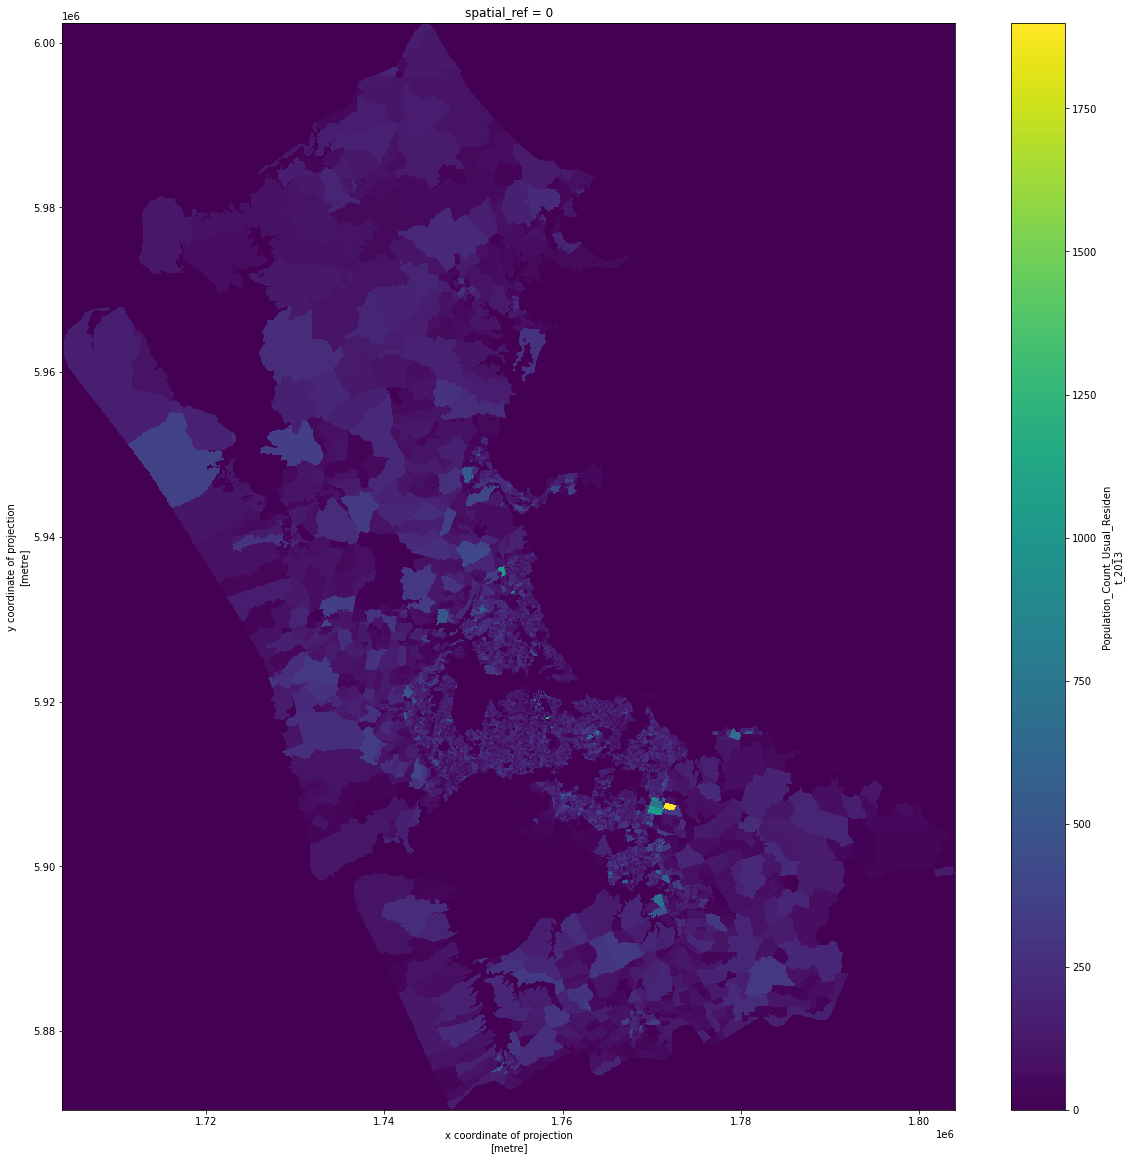

In [22]:
pop2013_cube.Population_Count_Usual_Resident_2013.plot()
outfile = "output/pop2013.tif"
if not os.path.isfile(outfile):
    # byte max value is 255, and we have larger values than that here. uint16 max value is 65535, which is fine
    pop2013_cube.Population_Count_Usual_Resident_2013.rio.to_raster(outfile, dtype=np.uint16)

In [23]:
%%time
pop2018 = pd.read_file("input/statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip!2018-census-electoral-population-meshblock-2020.gdb")

CPU times: user 9.17 s, sys: 20 ms, total: 9.19 s
Wall time: 9.18 s


In [24]:
%%time
pop2018 = pd.clip(pop2018, AKL)

CPU times: user 23.4 s, sys: 0 ns, total: 23.4 s
Wall time: 23.4 s


In [25]:
display(pop2018.sample(5))

MB2020_V2_00  General_Electoral_Population  Maori_Electoral_Population  \
46717      4003802                           111                        -999   
17952      0780100                           141                          18   
17761      0681333                            75                        -999   
15229      0426800                           117                          24   
13844      0278006                            60                           9   

      GED2020_V1_00 GED2020_V1_00_NAME GED2020_V1_00_NAME_ASCII MED2020_V1_00  \
46717           063       Whangaparāoa             Whangaparaoa             5   
17952           022           Manurewa                 Manurewa             3   
17761           004             Botany                   Botany             3   
15229           001   Auckland Central         Auckland Central             3   
13844           019            Kelston                  Kelston             5   

      MED2020_V1_00_NAME MED2020_V1_00_NAME_ASCII  LAND_AREA_SQ_KM  \
46717     Te Tai Tokerau           Te Tai Tokerau         0.038849   
17952    Tāmaki Makaurau          Tamaki Makaurau         0.078307   
17761    Tāmaki Makaurau          Tamaki Makaurau         0.054599   
15229    Tāmaki Makaurau          Tamaki Makaurau         0.042652   
13844     Te Tai Tokerau           Te Tai Tokerau         0.026429   

       AREA_SQ_KM  Shape_Length  \
46717    0.038849   1148.235175   
17952    0.078307   1478.686123   
17761    0.054599   1417.259611   
15229    0.042652    990.411265   
13844    0.026429    805.472895   

                                                geometry  
46717  POLYGON ((1755239.177 5945271.315, 1755380.475...  
17952  POLYGON ((1767724.492 5901589.495, 1767946.895...  
17761  POLYGON ((1769859.072 5913432.442, 1769863.182...  
15229  POLYGON ((1754642.773 5920197.903, 1754652.332...  
13844  POLYGON ((1744736.483 5914778.115, 1744758.074...

In [26]:
pop2018.General_Electoral_Population.replace(-999, 0, inplace=True)

<AxesSubplot:ylabel='Frequency'>

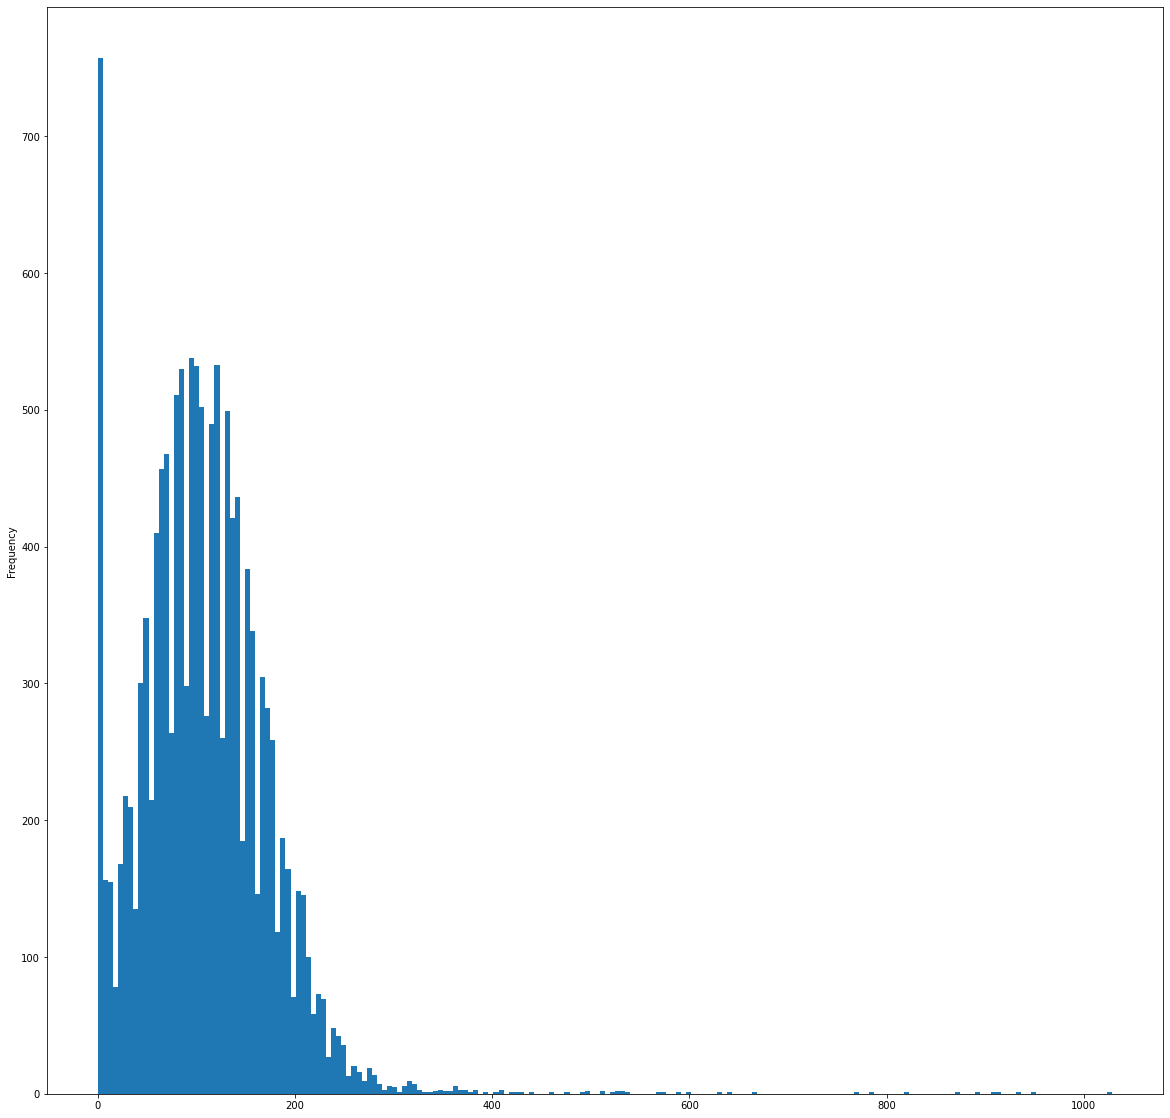

In [27]:
pop2018.General_Electoral_Population.plot(kind="hist", bins=200)

In [28]:
%%time
pop2018_cube = make_geocube(
    vector_data=pop2018,
    measurements=["General_Electoral_Population"],
    like=geocube, # Ensures dimensions match
    fill=0
)
pop2018_cube

CPU times: user 2.4 s, sys: 0 ns, total: 2.4 s
Wall time: 2.4 s


<xarray.Dataset>
Dimensions:                       (x: 1001, y: 1320)
Coordinates:
  * y                             (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                             (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                   int64 0
Data variables:
    General_Electoral_Population  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

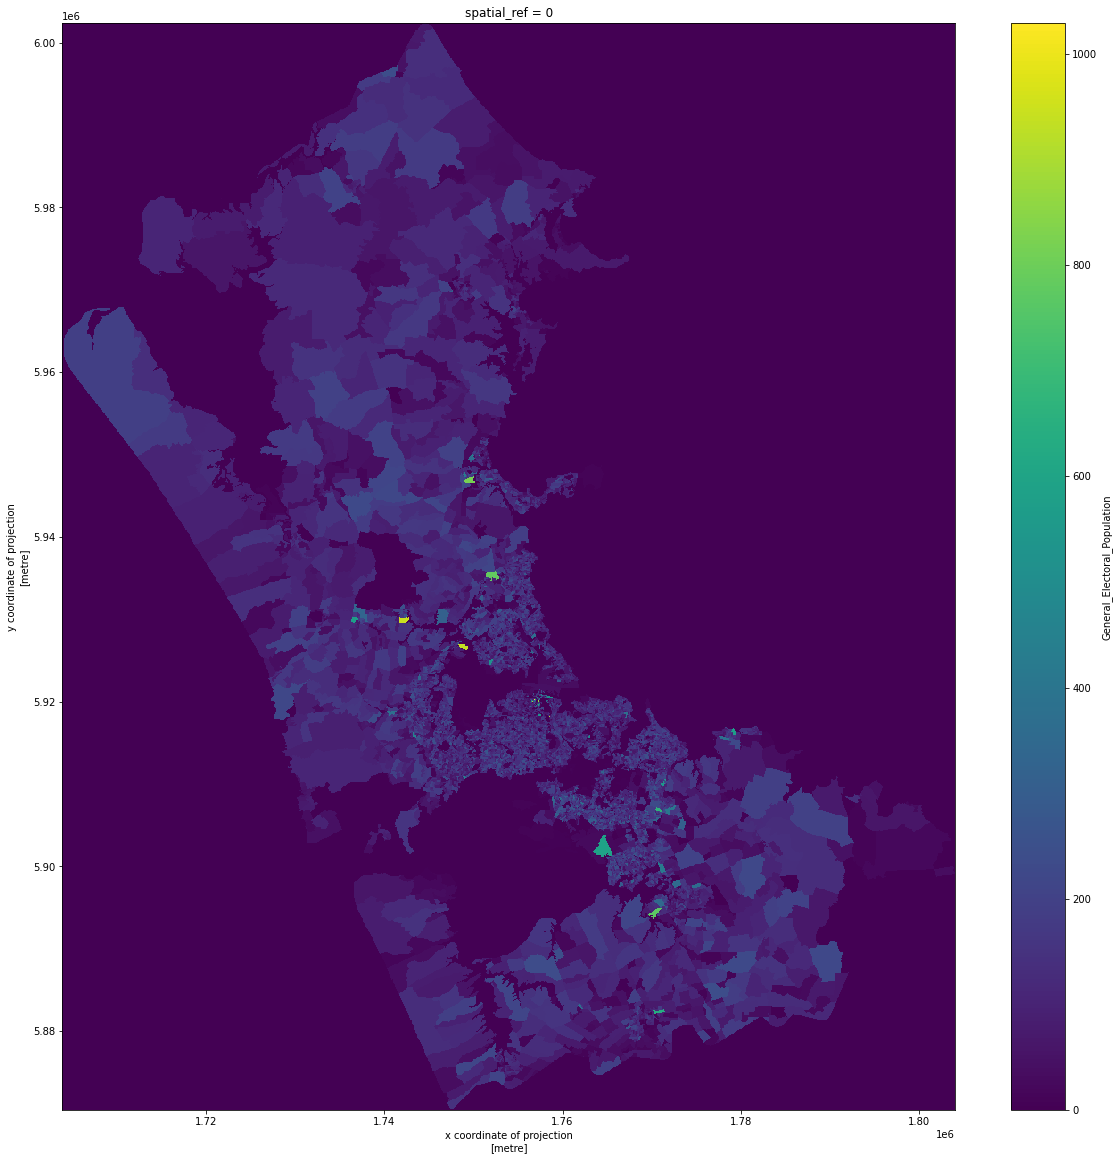

In [29]:
pop2018_cube.General_Electoral_Population.plot()
outfile = "output/pop2018.tif"
if not os.path.isfile(outfile):
    pop2018_cube.General_Electoral_Population.rio.to_raster(outfile, dtype=np.uint16)

## Distance from major roads

In [30]:
%%time
roads = pd.read_file("input/lds-nz-road-centrelines-topo-150k-FGDB.zip!nz-road-centrelines-topo-150k.gdb")

CPU times: user 8.82 s, sys: 41 µs, total: 8.82 s
Wall time: 8.81 s


In [31]:
%%time
akl_roads = pd.clip(roads, AKL)

CPU times: user 26.3 s, sys: 0 ns, total: 26.3 s
Wall time: 26.3 s


In [32]:
# If a road has a highway number (hway_num not None), it's a highway/motorway
mway = akl_roads[~akl_roads.hway_num.isna()].copy()
mway

t50_fid                  name_ascii macronated  \
512     100120610       KAIPARA COAST HIGHWAY          N   
2933      3198057             STATE HIGHWAY 1          N   
2934      3198059             STATE HIGHWAY 1          N   
3320      3200754                PAERATA ROAD          N   
3324      3200792      UPPER HARBOUR MOTORWAY          N   
...           ...                         ...        ...   
138240  100048291   AUCKLAND-WAIWERA MOTORWAY          N   
138301  100048432  AUCKLAND-HAMILTON MOTORWAY          N   
138337  100048532             STATE HIGHWAY 1          N   
138369  100048589            PORT ALBERT ROAD          N   
138680  100118365      SOUTH-WESTERN MOTORWAY          N   

                              name hway_num  rna_sufi  lane_count way_count  \
512          KAIPARA COAST HIGHWAY       16   3007739           2      None   
2933               STATE HIGHWAY 1        1   3027695           2      None   
2934               STATE HIGHWAY 1        1   3027695           2      None   
3320                  PAERATA ROAD       22   3000260           2      None   
3324        UPPER HARBOUR MOTORWAY       18   3047073           4      None   
...                            ...      ...       ...         ...       ...   
138240   AUCKLAND-WAIWERA MOTORWAY        1   3067966           7      None   
138301  AUCKLAND-HAMILTON MOTORWAY        1   3017109           1      None   
138337             STATE HIGHWAY 1        1   3027695           4      None   
138369            PORT ALBERT ROAD       16   3013274           2      None   
138680      SOUTH-WESTERN MOTORWAY       20   3018532           4      None   

       status surface                                           geometry  
512      None  sealed  LINESTRING (1732000.000 5944172.070, 1732048.5...  
2933     None  sealed  LINESTRING (1748581.508 5968975.145, 1748558.4...  
2934     None  sealed  LINESTRING (1748171.047 5971284.152, 1748129.9...  
3320     None  sealed  LINESTRING (1767236.112 5888088.508, 1767244.3...  
3324     None  sealed  LINESTRING (1747954.314 5927269.837, 1747970.0...  
...       ...     ...                                                ...  
138240   None  sealed  LINESTRING (1755881.018 5922863.734, 1755886.4...  
138301   None  sealed  LINESTRING (1765115.647 5909916.697, 1765092.7...  
138337   None  sealed  LINESTRING (1748892.089 5949596.727, 1748892.0...  
138369   None  sealed  LINESTRING (1734173.019 5980575.187, 1734175.6...  
138680   None  sealed  LINESTRING (1760066.252 5908184.133, 1760043.9...  

[426 rows x 11 columns]

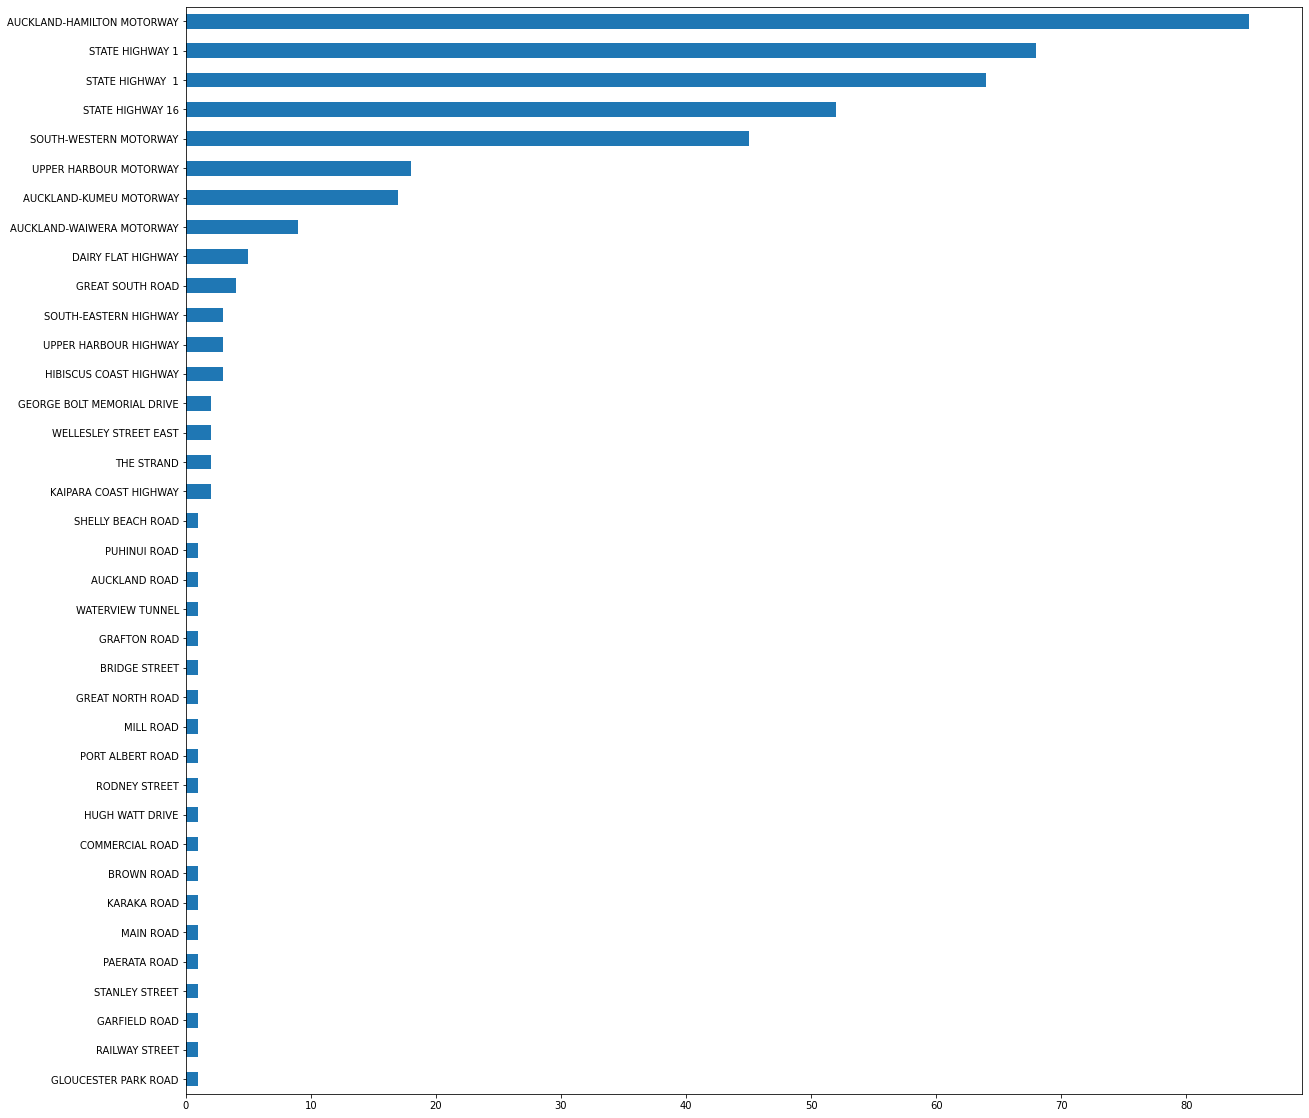

In [33]:
mway.name.value_counts().head(50).plot(kind="barh").invert_yaxis()

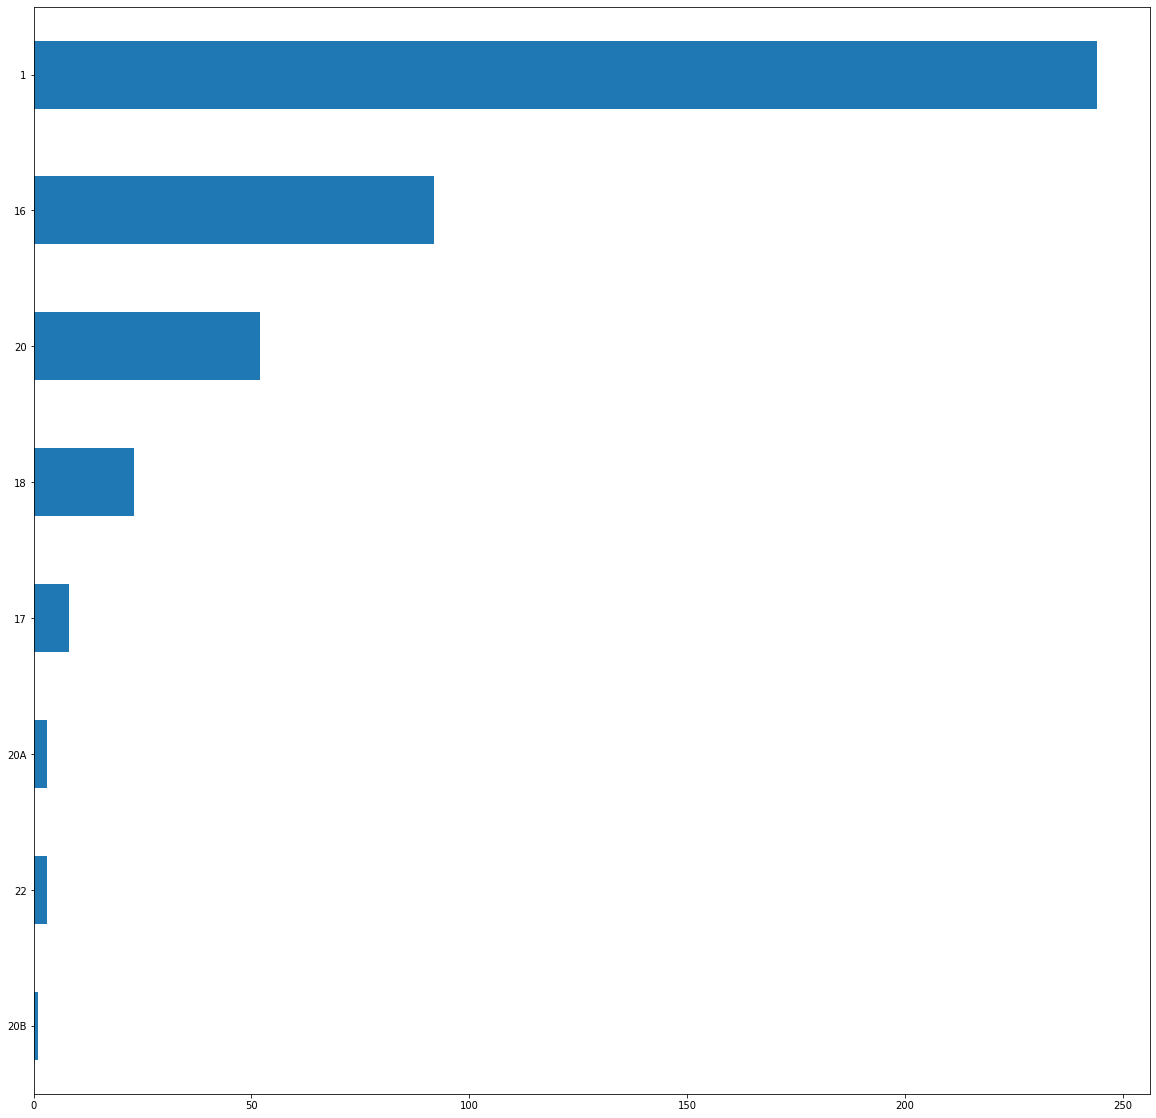

In [34]:
mway.hway_num.value_counts().head(50).plot(kind="barh").invert_yaxis()

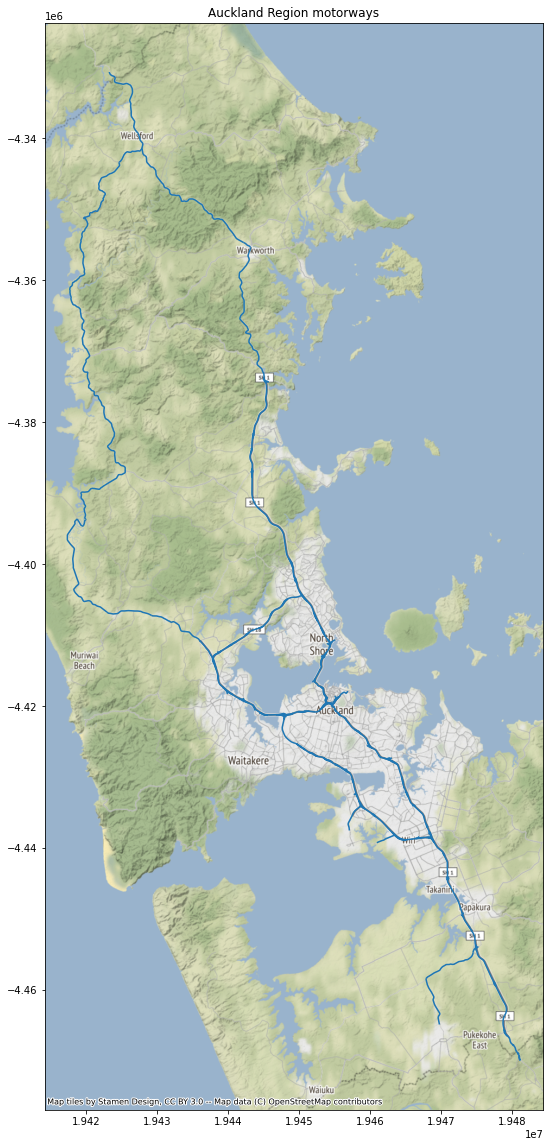

In [35]:
ax = mway.to_crs(epsg=3857).plot()
ax.set_title("Auckland Region motorways")
ctx.add_basemap(ax)

In [36]:
%%time
mway_cube = make_geocube(
    vector_data=mway,
    measurements=["lane_count"],
    like=geocube, # Ensures dimensions match
    fill=0, # 0 works fine here, as every mway has at least one lane
)
mway_cube

CPU times: user 261 ms, sys: 10 µs, total: 261 ms
Wall time: 259 ms


<xarray.Dataset>
Dimensions:      (x: 1001, y: 1320)
Coordinates:
  * y            (y) float64 6.002e+06 6.002e+06 ... 5.871e+06 5.87e+06
  * x            (x) float64 1.704e+06 1.704e+06 ... 1.804e+06 1.804e+06
    spatial_ref  int64 0
Data variables:
    lane_count   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

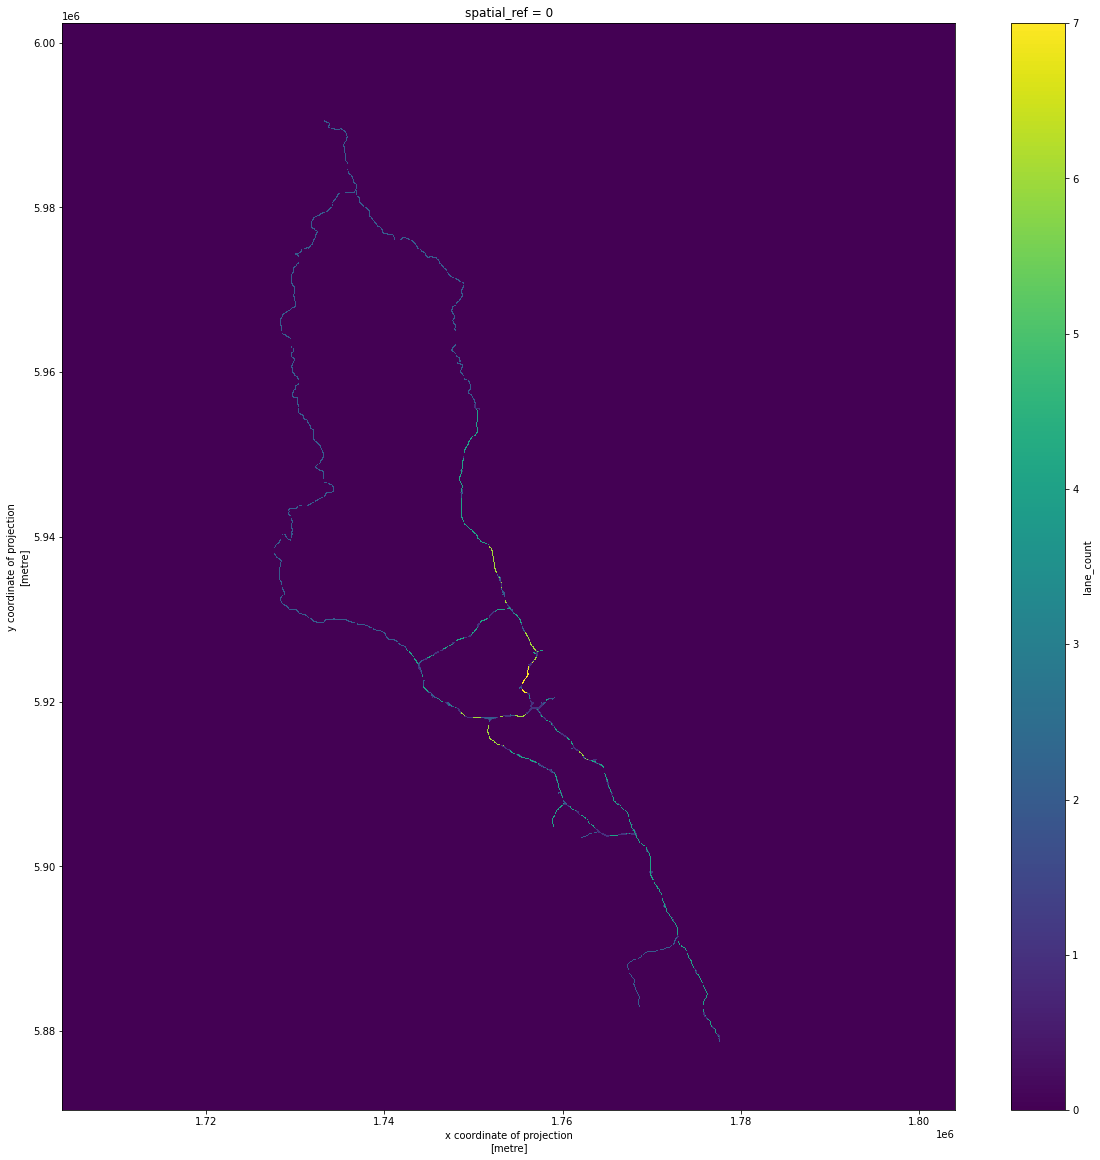

In [37]:
mway_cube.lane_count.plot()
outfile = "output/mway.tif"
if not os.path.isfile(outfile):
    mway_cube.lane_count.rio.to_raster(outfile, dtype=np.byte)

(1320, 1001)


Text(0.5, 1.0, 'Distance (m)')

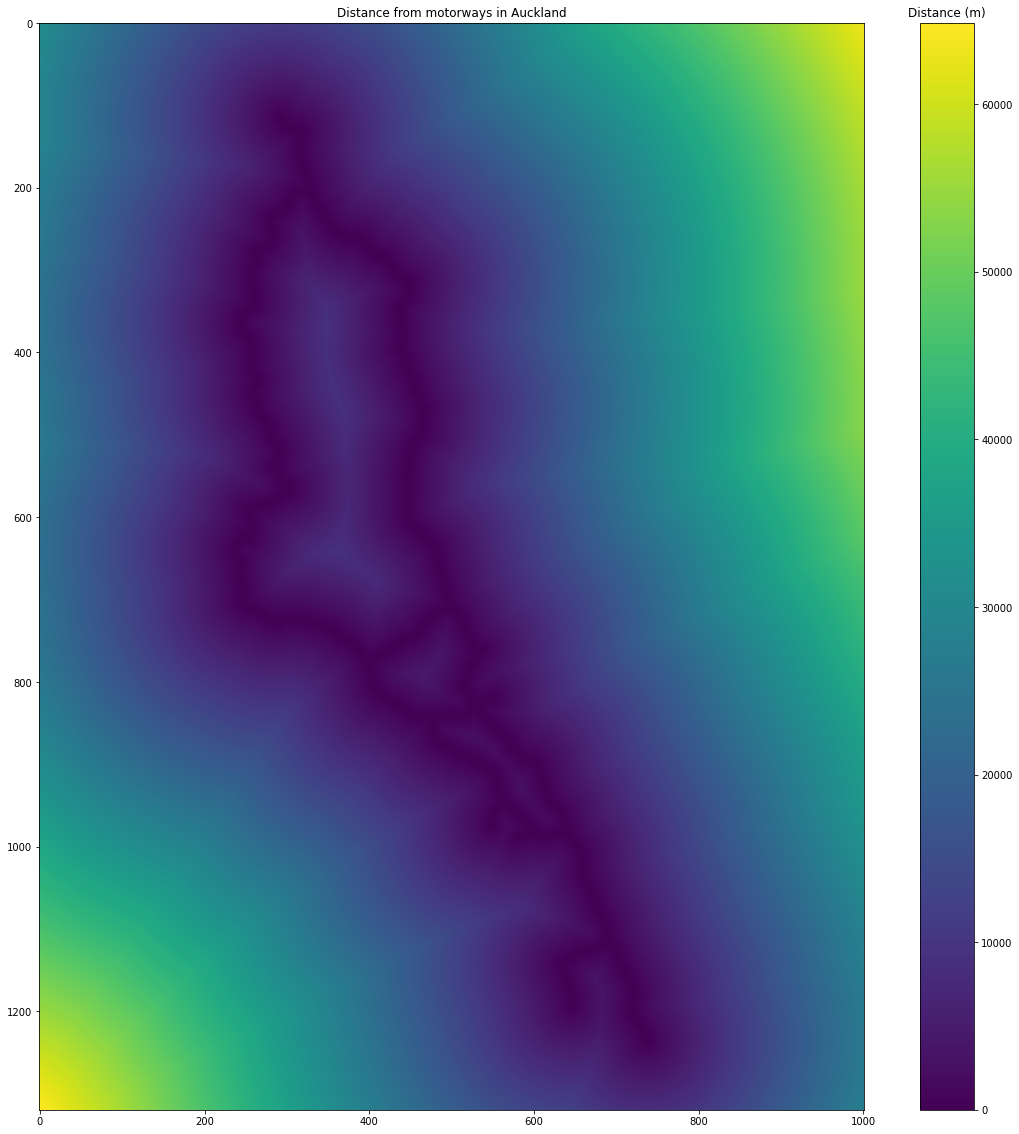

In [38]:
src_ds = gdal.Open("output/mway.tif")
srcband = src_ds.GetRasterBand(1)
dst_filename = "output/mway_dist.tif"
drv = gdal.GetDriverByName('GTiff')
dst_ds = drv.Create( dst_filename,
                     src_ds.RasterXSize, src_ds.RasterYSize, 1,
                     gdal.GetDataTypeByName('UInt16'))
dst_ds.SetGeoTransform( src_ds.GetGeoTransform() )
dst_ds.SetProjection( src_ds.GetProjectionRef() )
dstband = dst_ds.GetRasterBand(1)
prox = gdal.ComputeProximity(srcband,dstband,["DISTUNITS=GEO"]) # Encoded value is distance from motorway in meters
# Garbage collection of this variable flushes write
dst_ds = None
dst_ds = gdal.Open(dst_filename)
mway_dist = np.array(dst_ds.GetRasterBand(1).ReadAsArray())
print(mway_dist.shape)
plt.imshow(mway_dist)
plt.title("Distance from motorways in Auckland")
cb = plt.colorbar()
cb.ax.set_title("Distance (m)")

### Distance from CBD

(1320, 1001)
CPU times: user 451 ms, sys: 10 ms, total: 461 ms
Wall time: 459 ms


Text(0.5, 1.0, 'Distance (m)')

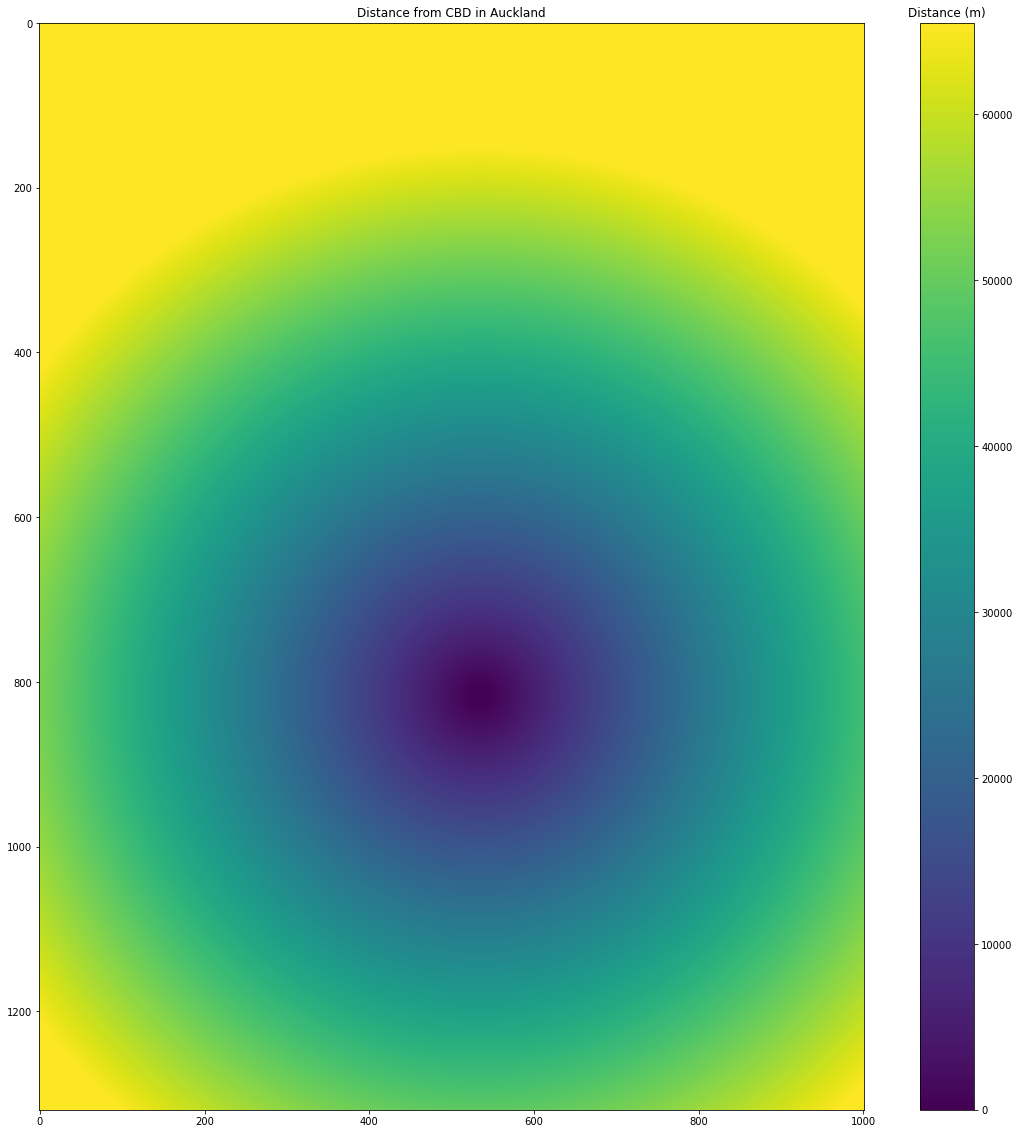

In [39]:
%%time
cbd = pop2018[pop2018.MB2020_V2_00 == "0433501"].copy()
cbd.geometry = cbd.geometry.buffer(1000)
cbd_cube = make_geocube(
    vector_data=cbd,
    like=geocube, # Ensures dimensions match
    fill=0
)
outfile = "output/cbd.tif"
if not os.path.isfile(outfile):
    cbd_cube.General_Electoral_Population.rio.to_raster(outfile, dtype=np.byte)
    
src_ds = gdal.Open("output/cbd.tif")
srcband = src_ds.GetRasterBand(1)
dst_filename = "output/cbd_dist.tif"
drv = gdal.GetDriverByName('GTiff')
dst_ds = drv.Create( dst_filename,
                     src_ds.RasterXSize, src_ds.RasterYSize, 1,
                     gdal.GetDataTypeByName('UInt16'))
dst_ds.SetGeoTransform( src_ds.GetGeoTransform() )
dst_ds.SetProjection( src_ds.GetProjectionRef() )
dstband = dst_ds.GetRasterBand(1)
prox = gdal.ComputeProximity(srcband,dstband,["DISTUNITS=GEO"]) # Encoded value is distance from motorway in meters
# Garbage collection of this variable flushes write
dst_ds = None
dst_ds = gdal.Open(dst_filename)
cbd_dist = np.array(dst_ds.GetRasterBand(1).ReadAsArray())
print(cbd_dist.shape)
plt.imshow(cbd_dist)
plt.title("Distance from CBD in Auckland")
cb = plt.colorbar()
cb.ax.set_title("Distance (m)")

# Slope

In [40]:
bounds = AKL.total_bounds.tolist()
bounds

[1703081.9789640256, 5870396.320936217, 1804839.668875325, 6002367.198185163]

In [41]:
zf = zipfile.ZipFile('input/lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip')
tiles = [file for file in zf.namelist() if file.endswith(".tif")]
tiles

['EJ.tif',
 'DM.tif',
 'EL.tif',
 'DL.tif',
 'DJ.tif',
 'FK.tif',
 'DK.tif',
 'EK.tif',
 'FL.tif']

In [42]:
tile_datasets = [rasterio.open(f'zip://input/lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip!{tile}') for tile in tiles]
DEM, transformation = rasterio.merge.merge(tile_datasets, bounds = bounds, res = (100,100), dtype=np.int16)

-32767 -18316.517014943143 697 (1, 1320, 1018)


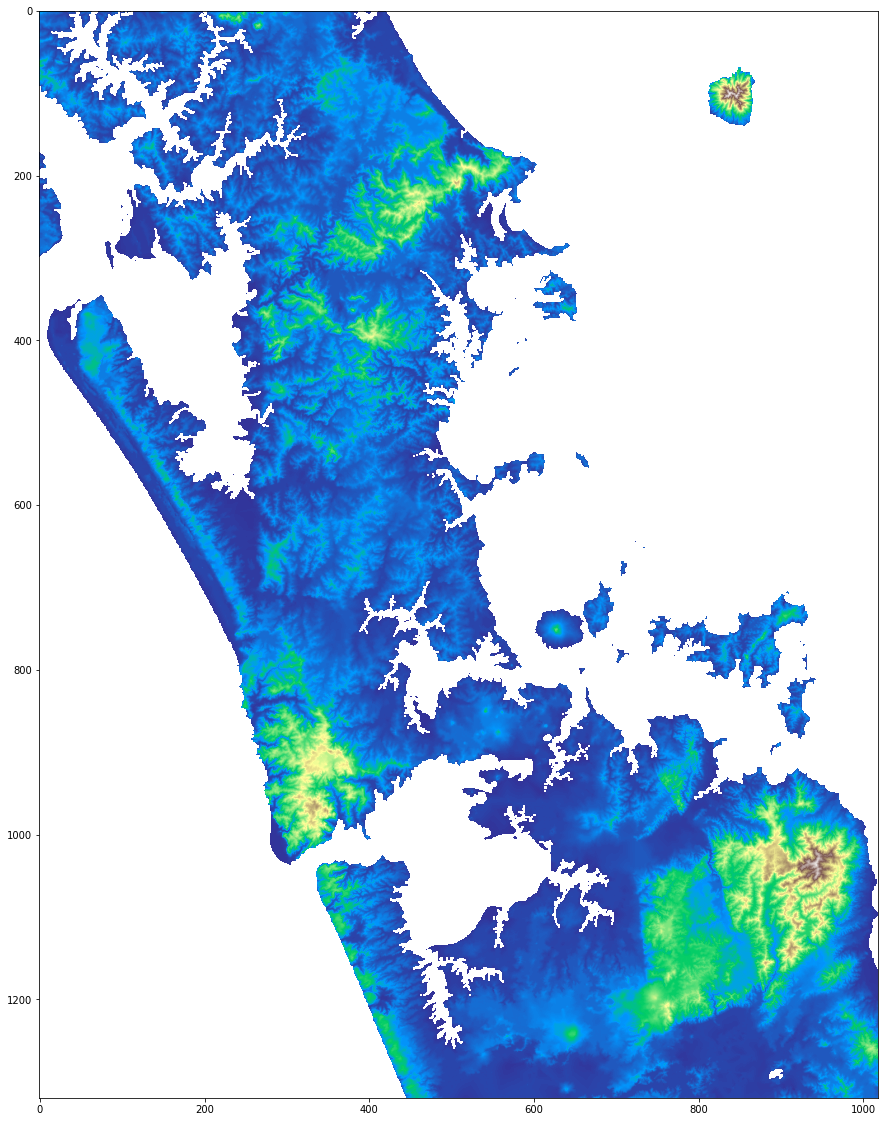

<AxesSubplot:>

In [43]:
print(np.nanmin(DEM), np.nanmean(DEM), np.nanmax(DEM), DEM.shape)
rasterio.plot.show(np.where(DEM>=0, DEM, np.nan), cmap='terrain')

In [45]:
cbd_dist = rasterio.open("output/cbd_dist.tif")
transformation, width, height = rasterio.warp.aligned_target(cbd_dist.transform, cbd_dist.width, cbd_dist.height, cbd_dist.res)

In [46]:
meta = tile_datasets[0].meta
print(meta)
meta.update({
    "dtype": "int16",
    "height": height,
    "width": width,
    "transform": transformation
})
print(meta)
outfile = "output/slope.tif"
if not os.path.isfile(outfile):
    with rasterio.open(outfile, "w", **meta) as dest:
       dest.write(DEM)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 3028, 'height': 8192, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(8.0, 0.0, 1679712.0,
       0.0, -8.0, 5963776.0)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 1001, 'height': 1320, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(100.0, 0.0, 1703900.0,
       0.0, -100.0, 6002400.0)}


In [47]:
rasters = [rasterio.open(f"output/{f}") for f in os.listdir("output")]
params = set([(r.shape, r.res, r.crs, r.count, r.bounds) for r in rasters])
print(params)
# Assert all rasters have the same shape, pixel size, CRS, number of bands, and bounds
assert len(params) == 1

{((1320, 1001), (100.0, 100.0), CRS.from_epsg(2193), 1, BoundingBox(left=1703900.0, bottom=5870400.0, right=1804000.0, top=6002400.0))}


In [48]:
!ls -Ggh output

total 22M
-rw-r--r-- 1 1.3M Apr 16 14:44 cbd.tif
-rw-r--r-- 1 2.6M Apr 16 14:53 cbd_dist.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_1996.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2001.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2008.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2012.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2018.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 mway.tif
-rw-r--r-- 1 2.6M Apr 16 14:53 mway_dist.tif
-rw-r--r-- 1 2.6M Apr 16 09:50 pop2013.tif
-rw-r--r-- 1 2.6M Apr 16 09:50 pop2018.tif
-rw-r--r-- 1 2.6M Apr 16 14:39 slope.tif
